In [1]:
"""
Use background TS obtained from scripts/02. Inject n_inj with `batch` injection
to find what a good batchNtrail is and what a good n_inj range is.

For the signal injection, spatial prior needs to he included.
"""

'\nUse background TS obtained from scripts/02. Inject n_inj with `batch` injection\nto find what a good batchNtrail is and what a good n_inj range is.\n\nFor the signal injection, spatial prior needs to he included.\n'

In [2]:
import os
import sys
print("Python version: ", end=' ')
print(sys.version)

import numpy as np
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
############# comment out below two lines on clusters ##########
%matplotlib inline
# %matplotlib notebook
################################################################
from glob import glob
timer = cy.timing.Timer()
time = timer.time

###### Local Import ######
import SETTING
paths = SETTING.PATH(osg=False)
print(paths)
LOCATION = paths.LOCATION
USER = paths.USER
ICDATA_DIR = paths.ICDATA_DIR
DATA_DIR = paths.DATA_DIR
ANA_DIR = paths.ANA_DIR

from utils import *

from scipy import sparse

Python version:  3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]

#### Working at GT ####

LOCATION: 	 GT
USER: 	 cchen641
ICDATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/analyses/online_GRECO/version-002-p04
DATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data
ANA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output



In [3]:
print("Background TS folder path: {}/allsky_scan/with_prior_background/twXXX/XXX.npz".format(ANA_DIR))


Background TS folder path: /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output/allsky_scan/with_prior_background/twXXX/XXX.npz


In [4]:
import argparse

######################### CONFIGURE ARGUEMENTS #############################
# p = argparse.ArgumentParser(description="Background Trials",
#                             formatter_class=argparse.RawTextHelpFormatter)
# p.add_argument("--grb_name", default="GRB180423A", type=str, help="Name of one GRB")
# p.add_argument("--batchNtrials", default=10, type=int, help="Number of trials in this batch")
# p.add_argument("--batchIndex", default=0, type=int, help="Index of current batch")
# p.add_argument("--tw_in_second", default=10, type=int, help="Length of the time window in seconds")
# p.add_argument("--ncpu", default=1, type=int, help="Number of CPU to give Csky")
# p.add_argument("--mode", default="production", type=str, help="Mode: production or testing")
# p.add_argument("--outfilename", default="", type=str, help="Output filename should have type .npz. Highly recommended on OSG")
# args = p.parse_args()
###########################################################################


### testing on jupyter ###

class args:
    grb_name = "GRB180423A"    # real healpix example
    # grb_name = "GRB190415A"    # fake healpix example
    batchNtrials = 20
    tw_in_second = 10
    ncpu = 4

##########################

In [5]:
print("\n===== Loading no-healpix df =====\n")
df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHeaplix.pkl")
# realHealpix: df.gbm & df.hasHealpix
# fakeHealpix: ~(df.gbm & df.hasHealpix)
df.head()

print("\n===== Loading healpix of {}=====\n".format(args.grb_name))   
try:
    healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format(args.grb_name))
    # healpix can contain negative values: faults due to Fermi-GBM
    healpix = np.maximum(healpix,0)
    ########## healpix reduce ##########
    healpix[healpix < isf_healpix(healpix, q=1.0)] = 0
except:
    raise Exception("Cannot load the healpix for grb: {}\n".format(args.grb_name))
    
grb_row = df.loc[df['grb_name'] == args.grb_name]
tw = args.tw_in_second/86400.
tw_start = grb_row.t_center - 0.5*tw
ra = grb_row.ra
dec = grb_row.dec
print("\n...Done\n")


===== Loading no-healpix df =====


===== Loading healpix of GRB180423A=====


...Done



In [6]:
print("\n===== Setting up csky =====\n")
data_dir = ICDATA_DIR
data_filenames = sorted(glob(data_dir + '/IC86_20*.data_with_angErr.npy'))
# sig_filenames = sorted(glob(data_dir + '/IC86_2012.nu*_merged_with_angErr.npy'))
# load nue only to save memory, never used in this .py
sig_filenames = sorted(glob(data_dir + '/IC86_2012.nue_merged_with_angErr.npy'))
grl_filenames = sorted(glob(data_dir + '/GRL/IC86_20*.data.npy'))

################ energy lower bound #############
min_log_e = np.log10(10)
#################################################
bins_sindec = np.linspace(-1, 1, 25+1)  
bins_logenergy = np.linspace(min_log_e, 5, 30+1)

data = [np.load(data_filename) for data_filename in data_filenames]
data = np.hstack(data)
sig = [np.load(sig_filename) for sig_filename in sig_filenames]
sig = np.hstack(sig)
grl = [np.load(grl_filename) for grl_filename in grl_filenames]
grl = np.hstack(grl)
if min_log_e is not None:
    data_mask = data['logE'] > min_log_e
    data = data[data_mask]
    sig_mask = sig['logE'] > min_log_e
    sig = sig[sig_mask]
    
dataset_spec = cy.selections.CustomDataSpecs.CustomDataSpec(data, sig, np.sum(grl['livetime']),
                                                     sindec_bins=bins_sindec,
                                                     logenergy_bins=bins_logenergy,
                                                     grl=grl, key='greco_v2.4', cascades=True)

ANA_DIR = cy.utils.ensure_dir(ANA_DIR)
# on OSG
# ana_dir = "./"
ana = cy.get_analysis(cy.selections.repo
                      , dataset_spec
                      , dir=ANA_DIR
                      , load_sig=True)  # to save memory  





===== Setting up csky =====

Setting up Analysis for:
greco_v2.4
Setting up greco_v2.4...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [21]:
#### used for spatial_prior_trial_runner
# conf = {
#     'ana': ana,
#     #### llh basics: csky.conf
#     'space': 'ps', # ps/fitps/template/prior
#     'time': 'transient', # utf/lc/transient
#     'energy': 'customflux', # fit/customflux
#     'flux': cy.hyp.PowerLawFlux(2),
#     #### inj.py - prior has some duplications against space's prior
#     'sig': 'transient', # ps/tw/lc/transient/template/prior
#     'full_sky': True,
#     'extended': True,
#     'mp_cpus': args.ncpu,
#     'cut_n_sigma': 3
#     }

# cy.CONF.update(conf)

#### used for basic trial_runner
conf = {
    'ana': ana,
    #### llh basics: csky.conf
    'space': 'prior', # ps/fitps/template/prior
    'time': 'transient', # utf/lc/transient
    'energy': 'customflux', # fit/customflux
    'flux': cy.hyp.PowerLawFlux(2),
    #### inj.py - prior has some duplications against space's prior
    'sig': 'transient', # ps/tw/lc/transient/template/prior
    'full_sky': True,
    'extended': True,
    'mp_cpus': args.ncpu,
    'cut_n_sigma': 3
}

cy.CONF.update(conf)

In [22]:
cy.CONF

{'mp_cpus': 4,
 'ana': Analysis(keys=[greco_v2.4]),
 'space': 'prior',
 'time': 'transient',
 'energy': 'customflux',
 'flux': PowerLawFlux(gamma=2),
 'sig': 'transient',
 'full_sky': True,
 'extended': True,
 'cut_n_sigma': 3}

In [23]:
bg_files = glob(ANA_DIR+"/allsky_scan/with_prior_background/tw{}/{}*.npz".format(args.tw_in_second, args.grb_name))
bg = cy.dists.Chi2TSD(np.ravel([sparse.load_npz(bg_file).toarray() for bg_file in bg_files]))
bg

Chi2TSD(1000000 trials, eta=0.021, ndof=1.637, median=0.000 (from fit 0.000))

In [24]:
print(bg.description)

Chi2TSD from 1000000 trials:
           eta = 0.021
          ndof = 1.637
           loc = 0.000
         scale = 1.728
Thresholds from trials:
        median = 0.000
       1 sigma = 0.00
       2 sigma = 0.00
       3 sigma = 8.32
       4 sigma = 20.82
       5 sigma = 36.76
Thresholds from fit:
        median = 0.000
       1 sigma = 0.00
       2 sigma = 0.00
       3 sigma = 8.32
       4 sigma = 20.82
       5 sigma = 36.76


/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


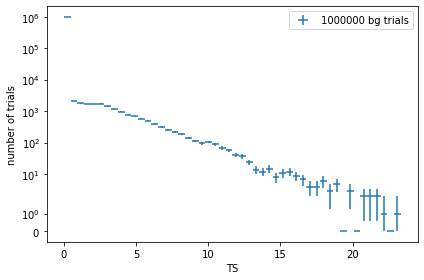

In [25]:
fig, ax = plt.subplots()

# csky uses histlite all over the place for PDF management
# the background distribution fit integrates with histlite as well
h = bg.get_hist(bins=50)
hl.plot1d(ax, h, crosses=True,
          label='{} bg trials'.format(bg.n_total))

# # compare with the chi2 fit:
# x = h.centers[0]
# norm = h.integrate().values
# ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
#             label=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$'.format(bg.ndof, bg.eta))

# always label your plots, folks
ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.set_yscale('symlog')
ax.legend()
plt.tight_layout()

In [26]:
src = cy.sources(
    ra=ra,
    dec=dec,
    deg=True,
    mjd=tw_start, 
    sigma_t=np.zeros_like(tw), 
    t_100=tw,  # in days
    prior=[hl.heal.HealHist(healpix)],
    name=args.grb_name
)

# sptr = cy.get_spatial_prior_trial_runner(conf=cy.CONF
#                                          ,src_tr=src
#                                          ,llh_priors=[healpix]
#                                          ,cut_n_sigma=5.) # src_tr is must for transient

tr = cy.get_trial_runner(ana=ana, src=src)

In [27]:
tr

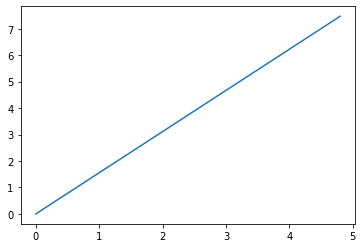

In [35]:
# sptr.to_E2dNdE(2, E0=100, unit=1e1)
x = np.r_[0:5:0.2]
y = tr.to_E2dNdE(x, E0=100, unit=1e1)
    
plt.plot(np.array(x), np.array(y))


In [ ]:
with time('ps sensitivity'):
    sens = sptr.find_n_sig(
        # ts, threshold
        bg.median(),
        # beta, fraction of trials which should exceed the threshold
        0.9,
        # n_inj step size for initial scan
        n_sig_step=0.2,
        # this many trials at a time
        batch_size=10,
        # tolerance, as estimated relative error
        tol=.10,
        first_batch_size=10
    )

In [ ]:
bg.median()